
#**Классификация текстов. Получение эмбеддингов**

---



**Классификация токсичных комментариев**

Что такое классификация токсичных комментариев?
Класс токсичности относится к любому комментарию или тексту, содержащему оскорбительные или обидные слова. Это может включать в себя оскорбления, нецензурные выражения или другие оскорбительные выражения.

Каждый метод классификации можно разделить на три группы в зависимости от количества используемых категорий:

1. Бинарная классификация:

Это тип контролируемой задачи машинного обучения, которая классифицирует данные на две взаимоисключающие группы или категории. Эти две категории можно классифицировать как истинные и ложные, 0 и 1, положительные и отрицательные и т. д.

При классификации токсичных комментариев модель обучена прогнозировать, является ли комментарий токсичным (класс 1) или нетоксичным (класс 0).



---



Dataset: https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data

In [ ]:
!pip install torch
!pip install trasformers
!pip install datasets
!pip install -U "tensorflow-text==2.13.*"
!pip install "tf-models-official==2.13.*"

In [ ]:
import numpy as np
import pandas as pd

#data visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
#to avoid warnings
import warnings
warnings.filterwarnings('ignore')

Датасет: https://drive.google.com/file/d/1ROUWDmAOeOAQZdADkfVmESPofKTYWnwf/view?usp=sharing

In [ ]:
data = pd.read_csv("test.csv")

In [ ]:
len(data)

153164

In [ ]:
data_labels = pd.read_csv("/content/test_labels.csv")

In [ ]:
data.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [ ]:
data_labels.head

<bound method NDFrame.head of                       id  toxic  severe_toxic  obscene  threat  insult  \
0       00001cee341fdb12     -1            -1       -1      -1      -1   
1       0000247867823ef7     -1            -1       -1      -1      -1   
2       00013b17ad220c46     -1            -1       -1      -1      -1   
3       00017563c3f7919a     -1            -1       -1      -1      -1   
4       00017695ad8997eb     -1            -1       -1      -1      -1   
...                  ...    ...           ...      ...     ...     ...   
153159  fffcd0960ee309b5     -1            -1       -1      -1      -1   
153160  fffd7a9a6eb32c16     -1            -1       -1      -1      -1   
153161  fffda9e8d6fafa9e     -1            -1       -1      -1      -1   
153162  fffe8f1340a79fc2     -1            -1       -1      -1      -1   
153163  ffffce3fb183ee80     -1            -1       -1      -1      -1   

        identity_hate  
0                  -1  
1                  -1  
2                  -1  
3                  -1  
4                  -1  
...               ...  
153159             -1  
153160             -1  
153161             -1  
153162             -1  
153163             -1  

[153164 rows x 7 columns]>

In [ ]:
merged_df = pd.merge(data_labels, data, on='id', how='inner')

In [ ]:
data  = merged_df.copy()

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             153164 non-null  object
 1   toxic          153164 non-null  int64 
 2   severe_toxic   153164 non-null  int64 
 3   obscene        153164 non-null  int64 
 4   threat         153164 non-null  int64 
 5   insult         153164 non-null  int64 
 6   identity_hate  153164 non-null  int64 
 7   comment_text   153164 non-null  object
dtypes: int64(6), object(2)
memory usage: 9.3+ MB


In [ ]:
column_labels = data.columns.tolist()[2:]

In [ ]:
column_labels

['severe_toxic',
 'obscene',
 'threat',
 'insult',
 'identity_hate',
 'comment_text']

In [ ]:
data = data[column_labels]

In [ ]:
data.replace(-1, 1, inplace = True)

In [ ]:
data = data.sample(frac = 1, random_state = 10).reset_index(drop=True)

In [ ]:
label_counts = data[['severe_toxic',
 'obscene',
 'threat',
 'insult',
 'identity_hate']].sum().sort_values()

Text(0.5, 1.0, 'Distribution')

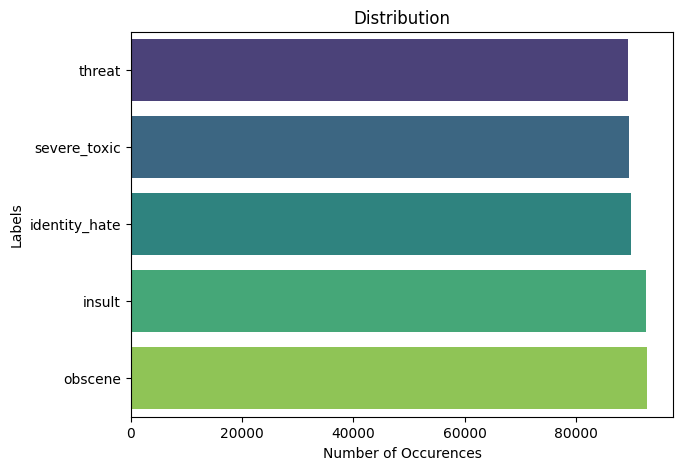

In [ ]:
plt.figure(figsize = (7, 5))

ax = sns.barplot(x = label_counts.values,
                 y = label_counts.index, palette = 'viridis')

plt.xlabel('Number of Occurences')
plt.ylabel('Labels')
plt.title('Distribution')

In [ ]:
label_counts

,0
threat,89397
severe_toxic,89553
identity_hate,89898
insult,92613
obscene,92877


In [ ]:
data.head(3)

,severe_toxic,obscene,threat,insult,identity_hate,comment_text
0,1,1,1,1,1,""" \n {| style=""""background-color:#ddcef2; padd..."
1,1,1,1,1,1,== Editor Boredwhytekid need to learn how to l...
2,1,1,1,1,1,** I cleaned up a lot of this Sock Puppet's un...


In [ ]:
data.comment_text[0]

':I meant to notify you yesterday that I had removed those tags.  Speedy deletion tags are for articles that do not indicate why the subject is important.  Those articles had an indication of importance, being a player for a CFL team (regardless of if they had played or not).  Not meeting WP:ATHLETE is not criteria for speedy deletion, proposed deletion or AfD is the way to go if you think they do not belong on Wikipedia.  If you put them up at AfD I will be sure to weigh in.  Cheers.'

In [ ]:
train_toxic = data[data[['severe_toxic',
 'obscene',
 'threat',
 'insult',
 'identity_hate']].sum(axis=1) > 0]

In [ ]:
train_clean = data[data[['severe_toxic',
 'obscene',
 'threat',
 'insult',
 'identity_hate']].sum(axis=1) == 0]

In [ ]:
num_toxic = len(train_toxic)
num_clean = len(train_clean)

In [ ]:
num_toxic

93719

In [ ]:
num_clean

59445

In [ ]:
plot_data = pd.DataFrame({'Category':['Toxic', 'Clean'],
                         'Count':[num_toxic, num_clean]})

In [ ]:
plot_data

,Category,Count
0,Toxic,93719
1,Clean,59445


Text(0.5, 1.0, 'Distribution of Toxic&Clean comments')

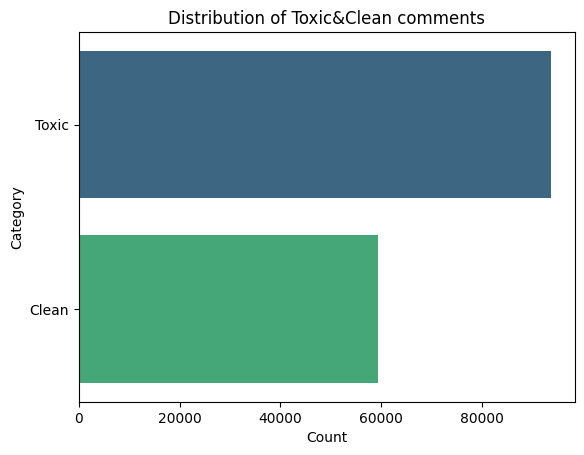

In [ ]:
ax = sns.barplot(x = 'Count', y = 'Category', data = plot_data, palette = 'viridis')
plt.title('Distribution of Toxic&Clean comments')

In [ ]:
train_toxic.shape

(93719, 6)

In [ ]:
train_clean.shape

(59445, 6)

In [ ]:
from sklearn.utils import resample

In [ ]:
train_clean

,severe_toxic,obscene,threat,insult,identity_hate,comment_text
5,0,0,0,0,0,==Sockpuppet== \n I am not a sockpuppet
8,0,0,0,0,0,""" \n :There's a thread at ANI which gives more..."
10,0,0,0,0,0,==Thanks== \n a lot for writing that Arbitrati...
16,0,0,0,0,0,:::Try Tolstoy's What is Art?
18,0,0,0,0,0,== \n\n This article looks like written by Kre...
...,...,...,...,...,...,...
153154,0,0,0,0,0,== Nanjing Massacre and the UN == \n\n Mel - w...
153156,0,0,0,0,0,:I think you should. The 1st link you give is ...
153158,0,0,0,0,0,* How do I trigger a review now that I've adde...
153160,0,0,0,0,0,== Semi-automated template substitution == \n ...


In [ ]:
data_sampled = pd.concat([train_clean, train_toxic], axis = 0)

In [ ]:
data_sampled = data_sampled.sample(frac = 1, random_state = 10)

In [ ]:
data_sampled

,severe_toxic,obscene,threat,insult,identity_hate,comment_text
53505,1,1,1,1,1,"""Please do not add nonsense to Wikipedia. It i..."
81188,1,1,1,1,1,""" \n\n \n ==Nasoni Roko == \n Thanks for prev..."
122205,1,1,1,1,1,":::::::::::::Hmmmm, must be why I like reading..."
136845,1,1,1,1,1,Seems map is outdated. Both Serbia and Bosnia-...
7035,0,0,0,0,0,"I didn't mean to deliver offense, I just meant..."
...,...,...,...,...,...,...
24212,0,0,0,0,0,""" \n :::We have sufficient sources for DN bein..."
75420,1,1,1,1,1,:::: Let's all go for EgoBooster instead of De...
55775,1,1,1,1,1,of dubious value you are totally wrong. \n ol...
57726,1,1,1,1,1,"''''''''''Yes, I as well have been blessed wit..."


In [ ]:
import re
import string
import gensim
import spacy

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
data_sampled['text_clean'] = data_sampled.comment_text.apply(clean_text)

In [ ]:
data_sampled['text_clean'] = data_sampled.comment_text

In [ ]:
data_sampled

,severe_toxic,obscene,threat,insult,identity_hate,comment_text,text_clean
53505,1,1,1,1,1,"""Please do not add nonsense to Wikipedia. It i...","""Please do not add nonsense to Wikipedia. It i..."
81188,1,1,1,1,1,""" \n\n \n ==Nasoni Roko == \n Thanks for prev...",""" \n\n \n ==Nasoni Roko == \n Thanks for prev..."
122205,1,1,1,1,1,":::::::::::::Hmmmm, must be why I like reading...",":::::::::::::Hmmmm, must be why I like reading..."
136845,1,1,1,1,1,Seems map is outdated. Both Serbia and Bosnia-...,Seems map is outdated. Both Serbia and Bosnia-...
7035,0,0,0,0,0,"I didn't mean to deliver offense, I just meant...","I didn't mean to deliver offense, I just meant..."
...,...,...,...,...,...,...,...
24212,0,0,0,0,0,""" \n :::We have sufficient sources for DN bein...",""" \n :::We have sufficient sources for DN bein..."
75420,1,1,1,1,1,:::: Let's all go for EgoBooster instead of De...,:::: Let's all go for EgoBooster instead of De...
55775,1,1,1,1,1,of dubious value you are totally wrong. \n ol...,of dubious value you are totally wrong. \n ol...
57726,1,1,1,1,1,"''''''''''Yes, I as well have been blessed wit...","''''''''''Yes, I as well have been blessed wit..."


In [ ]:
toxic = []
for i in range(len(data_sampled)):
    if data_sampled[['severe_toxic',
 'obscene',
 'threat',
 'insult',
 'identity_hate']].iloc[i].sum() > 0:
        toxic.append(1)
    else:
        toxic.append(0)


In [ ]:
column_labels

['severe_toxic',
 'obscene',
 'threat',
 'insult',
 'identity_hate',
 'comment_text']

In [ ]:
data_sampled

,severe_toxic,obscene,threat,insult,identity_hate,comment_text,text_clean
53505,1,1,1,1,1,"""Please do not add nonsense to Wikipedia. It i...","""Please do not add nonsense to Wikipedia. It i..."
81188,1,1,1,1,1,""" \n\n \n ==Nasoni Roko == \n Thanks for prev...",""" \n\n \n ==Nasoni Roko == \n Thanks for prev..."
122205,1,1,1,1,1,":::::::::::::Hmmmm, must be why I like reading...",":::::::::::::Hmmmm, must be why I like reading..."
136845,1,1,1,1,1,Seems map is outdated. Both Serbia and Bosnia-...,Seems map is outdated. Both Serbia and Bosnia-...
7035,0,0,0,0,0,"I didn't mean to deliver offense, I just meant...","I didn't mean to deliver offense, I just meant..."
...,...,...,...,...,...,...,...
24212,0,0,0,0,0,""" \n :::We have sufficient sources for DN bein...",""" \n :::We have sufficient sources for DN bein..."
75420,1,1,1,1,1,:::: Let's all go for EgoBooster instead of De...,:::: Let's all go for EgoBooster instead of De...
55775,1,1,1,1,1,of dubious value you are totally wrong. \n ol...,of dubious value you are totally wrong. \n ol...
57726,1,1,1,1,1,"''''''''''Yes, I as well have been blessed wit...","''''''''''Yes, I as well have been blessed wit..."


In [ ]:
data_sampled.drop(columns=column_labels, inplace = True)

In [ ]:
data_sampled['toxic'] = toxic

In [ ]:
data_sampled.reset_index(drop=True)

,text_clean,toxic
0,"""Please do not add nonsense to Wikipedia. It i...",1
1,""" \n\n \n ==Nasoni Roko == \n Thanks for prev...",1
2,":::::::::::::Hmmmm, must be why I like reading...",1
3,Seems map is outdated. Both Serbia and Bosnia-...,1
4,"I didn't mean to deliver offense, I just meant...",0
...,...,...
153159,""" \n :::We have sufficient sources for DN bein...",0
153160,:::: Let's all go for EgoBooster instead of De...,1
153161,of dubious value you are totally wrong. \n ol...,1
153162,"''''''''''Yes, I as well have been blessed wit...",1


In [ ]:
data_sampled.toxic.value_counts()

,count
toxic,
1,93719
0,59445




---



In [ ]:
!pip install sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer

In [ ]:
import torch

In [ ]:
torch.cuda.is_available()

True

In [ ]:
model = SentenceTransformer('google/mt5-small')

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
test_emb_en = model.encode("Hello, my dog is cute")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
test_emb_en.shape

(512,)

In [ ]:
test_emb_en

In [ ]:
test_emb_rus = model.encode("I Love my dog")

In [ ]:
test_emb_rus.shape

(512,)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity(test_emb_en.reshape(1, -1), test_emb_rus.reshape(1, -1))

array([[0.77425784]], dtype=float32)

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
def get_embedding(text):
    emb = model.encode(text)
    return emb

In [ ]:
data_sampled.dropna(inplace=True)

NameError: name 'data_sampled' is not defined

In [ ]:
from tqdm import tqdm

In [ ]:
embeddings = []
for i in tqdm(range(len(data_sampled))):
    embeddings.append(get_embedding(data_sampled.text_clean.iloc[i]))

100%|██████████| 153164/153164 [19:29<00:00, 131.00it/s]


In [ ]:
data_sampled['embeddings'] = embeddings

In [ ]:
data_sampled.to_csv('toxic_emddings.csv')

In [ ]:
data_sampled.toxic.value_counts()

,count
toxic,
1,3584
0,3584


In [ ]:
x = data_sampled['embeddings']
y = data_sampled['toxic']

In [ ]:
emb_list = []
for emb in x:
    emb_list.append(emb)

In [ ]:
x = np.array(emb_list)

In [ ]:
x.shape

(7168, 384)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x , y, test_size=0.20, random_state=10)

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr = LogisticRegression()
lr.fit(x_train, y_train)

LogisticRegression()

In [ ]:
lr_y_pred = lr.predict(x_test)
lr_score = accuracy_score(y_test, lr_y_pred)

print(f'Accuracy: {round(lr_score*100, 2)}%')

Accuracy: 61.51%


In [ ]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(768, 2), random_state=1)
clf.fit(x_train, y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(768, 2), random_state=1,
              solver='lbfgs')

In [ ]:
accuracy_score(y_test, clf.predict(x_test))*100

49.721059972106



---



Эмбеддинги: https://drive.google.com/file/d/1P8jA-FwNHHD0gGIwXTFHA6WsGJ8azKEZ/view?usp=sharing

In [ ]:
emb = pd.read_csv('/content/toxic_emb.csv')

In [ ]:
emb

,Unnamed: 0,text_clean,toxic
0,53505,"""Please do not add nonsense to Wikipedia. It i...",1
1,81188,""" \n\n \n ==Nasoni Roko == \n Thanks for prev...",1
2,122205,":::::::::::::Hmmmm, must be why I like reading...",1
3,136845,Seems map is outdated. Both Serbia and Bosnia-...,1
4,7035,"I didn't mean to deliver offense, I just meant...",0
...,...,...,...
153159,24212,""" \n :::We have sufficient sources for DN bein...",0
153160,75420,:::: Let's all go for EgoBooster instead of De...,1
153161,55775,of dubious value you are totally wrong. \n ol...,1
153162,57726,"''''''''''Yes, I as well have been blessed wit...",1


In [ ]:
from tqdm import tqdm
embeddings = []
for i in tqdm(range(len(emb))):
    embeddings.append(get_embedding(emb.text_clean.iloc[i]))

100%|██████████| 153164/153164 [18:32<00:00, 137.72it/s]


In [ ]:
emb['embeddings'] = embeddings

In [ ]:
#emb.to_csv('toxic_emb_1.csv')

In [ ]:
emb

,Unnamed: 0,text_clean,toxic,embeddings
0,53505,"""Please do not add nonsense to Wikipedia. It i...",1,"[-0.0038526116, 0.08941971, 0.066888556, 0.001..."
1,81188,""" \n\n \n ==Nasoni Roko == \n Thanks for prev...",1,"[-0.050076645, 0.082240574, -0.07909141, 0.015..."
2,122205,":::::::::::::Hmmmm, must be why I like reading...",1,"[-0.0574927, 0.040744323, -0.00069275755, -0.0..."
3,136845,Seems map is outdated. Both Serbia and Bosnia-...,1,"[0.08095959, 0.0051645003, 0.009899028, -0.017..."
4,7035,"I didn't mean to deliver offense, I just meant...",0,"[0.026514115, 0.03571935, -0.04835852, -0.0181..."
...,...,...,...,...
153159,24212,""" \n :::We have sufficient sources for DN bein...",0,"[-0.022549817, -0.053967938, 0.01212421, 0.032..."
153160,75420,:::: Let's all go for EgoBooster instead of De...,1,"[-0.12409702, 0.04509738, -0.039324492, -0.040..."
153161,55775,of dubious value you are totally wrong. \n ol...,1,"[-0.064991735, 0.0536378, -0.12373942, -0.0160..."
153162,57726,"''''''''''Yes, I as well have been blessed wit...",1,"[0.0076406826, 0.05866854, 0.080810666, 0.0295..."


In [ ]:
np.array(embeddings).shape

(153164, 384)

In [ ]:
embeddings[0].shape

(384,)

In [ ]:
emb.toxic.value_counts()

,count
toxic,
1,93719
0,59445


In [ ]:
torch.tensor(embeddings)

tensor([[-0.0039,  0.0894,  0.0669,  ...,  0.0033,  0.0377,  0.0011],
        [-0.0501,  0.0822, -0.0791,  ...,  0.0075,  0.0497, -0.0194],
        [-0.0575,  0.0407, -0.0007,  ...,  0.0673, -0.0390,  0.0174],
        ...,
        [-0.0650,  0.0536, -0.1237,  ..., -0.0686, -0.0318,  0.0419],
        [ 0.0076,  0.0587,  0.0808,  ..., -0.0072, -0.0998, -0.0819],
        [-0.0912,  0.0656, -0.0714,  ...,  0.0129,  0.0133, -0.0179]])

In [ ]:
torch.tensor(emb.toxic)

tensor([1, 1, 1,  ..., 1, 1, 1])

**Загружаем эмбеддинги**

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Пример: эмбеддинги и метки
embeddings = torch.tensor(embeddings) # 153164 samples, 384-dimensional embeddings
labels = torch.tensor(emb.toxic) # 153164 binary labels

# Создание Dataset и DataLoader
dataset = TensorDataset(embeddings, labels)
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

**Создание модели классификатора**


Создадим простую модель классификатора на основе полносвязных слоев.

In [ ]:
import torch.nn as nn

class TextClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(TextClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Инициализация модели
input_dim = 384  # Размерность эмбеддингов
num_classes = 2  # Количество классов
model = TextClassifier(input_dim, num_classes)

In [ ]:
model

TextClassifier(
  (fc1): Linear(in_features=384, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)

**Настройка оптимизатора и функции потерь**


Используем Adam оптимизатор и CrossEntropyLoss для задачи классификации.

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

model.train()
for epoch in range(10):  # Количество эпох
    for batch in train_loader:
        embeddings_batch, labels_batch = batch
        embeddings_batch, labels_batch = embeddings_batch.to(device), labels_batch.to(device)

        optimizer.zero_grad()
        outputs = model(embeddings_batch)
        loss = loss_fn(outputs, labels_batch)
        loss.backward()
        optimizer.step()

        print(f"Epoch: {epoch}, Loss: {loss.item()}")

Выходные данные были обрезаны до нескольких последних строк (5000).
Epoch: 9, Loss: 0.2505640983581543
Epoch: 9, Loss: 0.3032796382904053
Epoch: 9, Loss: 0.4676268696784973
Epoch: 9, Loss: 0.42460042238235474
Epoch: 9, Loss: 0.4776381254196167
Epoch: 9, Loss: 0.276638388633728
Epoch: 9, Loss: 0.30566832423210144
Epoch: 9, Loss: 0.1418929547071457
Epoch: 9, Loss: 0.3475513458251953
Epoch: 9, Loss: 0.5881705284118652
Epoch: 9, Loss: 0.7919341325759888
Epoch: 9, Loss: 0.32133495807647705
Epoch: 9, Loss: 0.3727452754974365
Epoch: 9, Loss: 0.48690366744995117
Epoch: 9, Loss: 0.27068865299224854
Epoch: 9, Loss: 0.6158151030540466
Epoch: 9, Loss: 0.3841182589530945
Epoch: 9, Loss: 0.3336739242076874
Epoch: 9, Loss: 0.22676493227481842
Epoch: 9, Loss: 0.437612384557724
Epoch: 9, Loss: 0.23441660404205322
Epoch: 9, Loss: 0.5137709379196167
Epoch: 9, Loss: 0.6904304027557373
Epoch: 9, Loss: 0.5128396153450012
Epoch: 9, Loss: 0.3618786334991455
Epoch: 9, Loss: 0.6425154209136963
Epoch: 9, Loss: 0

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch in train_loader:  # Используем train_loader для примера
        embeddings_batch, labels_batch = batch
        embeddings_batch, labels_batch = embeddings_batch.to(device), labels_batch.to(device)

        outputs = model(embeddings_batch)
        predictions = torch.argmax(outputs, dim=-1)
        correct += (predictions == labels_batch).sum().item()
        total += labels_batch.size(0)

accuracy = correct / total
print(f"Accuracy: {accuracy}")

Accuracy: 0.8535621947716173


In [ ]:
torch.save(model.state_dict(), './text_classifier.pth')

In [ ]:
model.load_state_dict(torch.load('./text_classifier.pth', weights_only=True))
model.eval()

TextClassifier(
  (fc1): Linear(in_features=384, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)

Практика



---



dataset 2: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

датасет: https://drive.google.com/file/d/1zcNQySiVLjGMuhGgxa4-xjz3UHA3nVCJ/view?usp=sharing

1. Загрузите и очистите данные
2. Визуализируйте распределение классов
3. Решите проблему дисбаланса классов.
4. Выполните предварительную обработку данных
5. Векторизовать используя методы из трансформеров
6. Обучить Модель по вашему выбору, либо написать свою.

7. Рассчитайте accuracy


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/IMDB Dataset.csv')

In [ ]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
df.sentiment.value_counts()

,count
sentiment,
positive,25000
negative,25000


In [ ]:
import re
import string
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
spacy.prefer_gpu()
nlp = spacy.load('en_core_web_sm')

In [ ]:
all_stopwords = STOP_WORDS

In [ ]:
all_stopwords = list(all_stopwords)

In [ ]:
all_stopwords_new = set(all_stopwords)

In [ ]:
def spacy_tokeniser(text):
    text = text.strip()
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.text not in all_stopwords_new]
    return tokens

In [ ]:
df['review_clean'] = df.review.apply(clean_text)

In [ ]:
df_1 = df[0:1000]

In [ ]:
df_1

,review,sentiment,review_clean
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production br br the...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,basically there s a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei s love in the time of money is...
...,...,...,...
995,Nothing is sacred. Just ask Ernie Fosselius. T...,positive,nothing is sacred just ask ernie fosselius t...
996,I hated it. I hate self-aware pretentious inan...,negative,i hated it i hate self aware pretentious inan...
997,I usually try to be professional and construct...,negative,i usually try to be professional and construct...
998,If you like me is going to see this in a film ...,negative,if you like me is going to see this in a film ...


In [ ]:
tokens = []
for i in tqdm(range(len(df_1))):
    tokens.append(spacy_tokeniser(df_1['review_clean'].iloc[i]))

100%|██████████| 1000/1000 [00:38<00:00, 25.94it/s]


In [ ]:
for i in tokens:
    for j in i:
        if len(j)<3 or ' ' in j or j == 'br':
            i.remove(j)

In [ ]:
df_1['tokens'] = tokens

In [ ]:
df_1

,review,sentiment,review_clean,tokens
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...,"[reviewer, mention, watch, episode, hook, righ..."
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production br br the...,"[wonderful, little, production, film, techniqu..."
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...,"[think, wonderful, way, spend, time, hot, summ..."
3,Basically there's a family where a little boy ...,negative,basically there s a family where a little boy ...,"[basically, family, little, boy, jake, think, ..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei s love in the time of money is...,"[petter, mattei, love, time, money, visually, ..."
...,...,...,...,...
995,Nothing is sacred. Just ask Ernie Fosselius. T...,positive,nothing is sacred just ask ernie fosselius t...,"[sacred, ask, ernie, fosselius, day, everybody..."
996,I hated it. I hate self-aware pretentious inan...,negative,i hated it i hate self aware pretentious inan...,"[hate, hate, self, aware, pretentious, inanity..."
997,I usually try to be professional and construct...,negative,i usually try to be professional and construct...,"[usually, try, professional, constructive, cri..."
998,If you like me is going to see this in a film ...,negative,if you like me is going to see this in a film ...,"[like, film, history, class, like, school, try..."


In [ ]:
from nltk.probability import FreqDist
import nltk

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [ ]:
def str_corpus(corpus):
    str_corpus = ''
    for i in corpus:
        str_corpus += ' ' + i
    str_corpus = str_corpus.strip()
    return str_corpus
# All words in the corpus
def get_corpus(data):
    corpus = []
    for phrase in data:
        for word in phrase:
            corpus.append(word)
    return corpus
# WordCloud
def get_wordCloud(corpus):
    wordCloud = WordCloud(background_color='white',
                              stopwords=STOPWORDS,
                              width=3000,
                              height=2500,
                              max_words=200,
                              random_state=42
                         ).generate(str_corpus(corpus))
    return wordCloud

<Axes: >

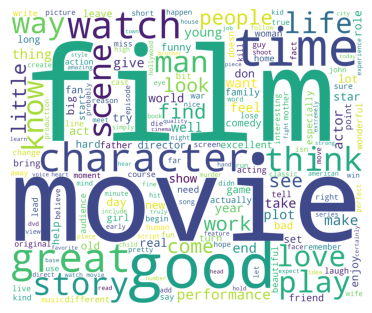

In [ ]:
toxic_corpus = get_corpus(df_1.tokens[df_1['sentiment']=='positive'])
procWordCloud = get_wordCloud(toxic_corpus)

fig = plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)

<Axes: >

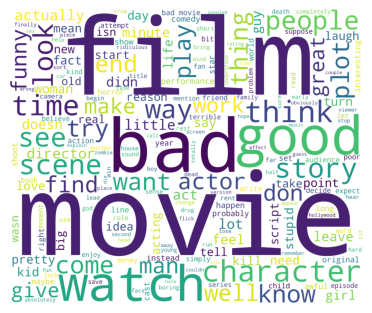

In [ ]:
non_toxic_corpus = get_corpus(df_1.tokens[df_1['sentiment']=='negative'])
procWordCloud = get_wordCloud(non_toxic_corpus)

fig = plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)

In [ ]:
fdist_negative = FreqDist(non_toxic_corpus)

In [ ]:
fdist_negative.most_common(10)

[('movie', 1190),
 ('film', 905),
 ('like', 463),
 ('bad', 433),
 ('good', 321),
 ('watch', 289),
 ('character', 276),
 ('time', 268),
 ('think', 255),
 ('see', 246)]

<Axes: title={'center': 'Top 10 Most Common Words in Corpus'}, xlabel='Samples', ylabel='Counts'>

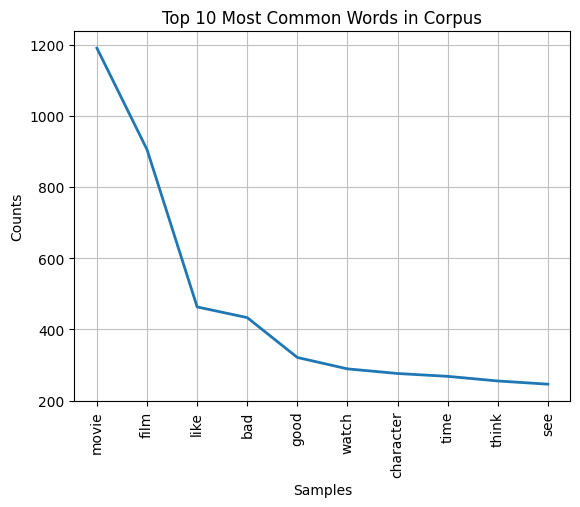

In [ ]:
fdist_negative.plot(10, title='Top 10 Most Common Words in Corpus',)

In [ ]:
fdist_positive = FreqDist(toxic_corpus)

In [ ]:
fdist_positive.most_common(10)

[('film', 964),
 ('movie', 936),
 ('good', 457),
 ('like', 397),
 ('time', 322),
 ('watch', 283),
 ('great', 280),
 ('story', 279),
 ('character', 270),
 ('think', 230)]

<Axes: title={'center': 'Top 10 Most Common Words in Corpus'}, xlabel='Samples', ylabel='Counts'>

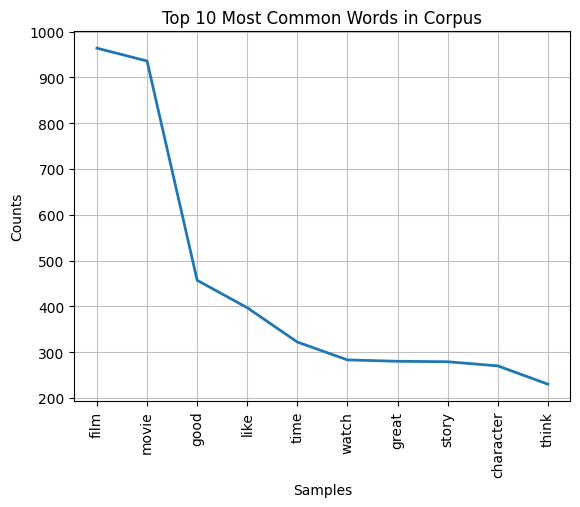

In [ ]:
fdist_positive.plot(10, title='Top 10 Most Common Words in Corpus',)